In [1]:
import glob
import numpy as np
import gpflow
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

In [2]:
import MATSgp
import matplotlib.pyplot as plt

HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


2021-08-11 10:54:36.316413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# set seed for reproducible results
np.random.seed(0)

# Read in some data

In [4]:
dat_files = glob.glob('../Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files.sort()
dat_files

['../Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv']

In [5]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [6]:
#Create information on each dataset
data_info_list = []

for i in range(len(dat)):
    data_info_list.append(MATSgp.SpectralDataInfo(fittable=False,
                                           mole_frac=0.01949,
                                           x_shift=0.0,
                                           nominal_temp=296,
                                           abun_ratio=1.0)
                         )

In [7]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

y = [d[:, 9] for d in dat]

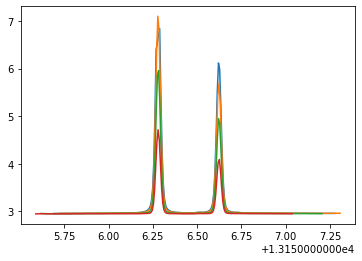

In [8]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i])
plt.show()

# Perform some fitting

In [9]:
#Define a noise scale to make training a little more robust
noise_scale = np.average([np.std(y[i][:10]) for i in range(len(y))])
print(noise_scale)

0.0008708101055790094


In [10]:
lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)

line_list = []
for i, line in lineparam_list.iterrows():
    line_list.append(MATSgp.lineshape_from_dataframe(line,
                                              limit_factor_dict={'SD_gamma_air':('factor', 2.0),
                                                                 'nu':('magnitude', 0.1),
                                                                 'sw':('factor', 2.0)},
                                              line_kwargs={'dset_list':data_info_list,
                                                           'linemix':MATSgp.linemix_from_dataframe(line,
                                                                linemix_kwargs={'fittable':(line['sw'] >= 1.0)}),
                                                           'cutoff':25,
                                                           'noise_scale_factor':noise_scale,
                                                           'fittable':(line['sw'] >= 1.0)},
                                             )
                    )

2021-08-11 10:54:36.570597: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
#And etalons
etalons = MATSgp.Etalon([0.00165, 0.00165, 0.00165, 0.00165],
                 [1.271443, 1.271443, 1.271443, 1.271443],
                 [-0.734156, -0.480252, -1.417825, -1.647160],
                 [np.min(xdat[:, 0]) for xdat in x],
                 noise_scale_factor=noise_scale,
                 fittable=True)
for param in ['amp', 'period', 'phase', 'ref_wave']:
    gpflow.set_trainable(etalons.params[param], True)


In [12]:
#And baselines, too!
baselines = MATSgp.Baseline([2.958, 2.959, 2.953, 2.950],
                     [0.002031, 0.001985, 0.001964, 0.001776],
                     [0.0, 0.0, 0.0, 0.0],
                     [np.min(xdat[:, 0]) for xdat in x],
                     noise_scale_factor=noise_scale,
                     fittable=True)
for param in ['c0', 'c1', 'c2', 'ref_wave']:
    gpflow.set_trainable(baselines.params[param], True)


In [13]:
#Put it all together in the combined mean function for the model
mean_func = MATSgp.ComboMeanFunc(line_list+[ #lineshape1, lineshape10, lineshape13, lineshape25, lineshape26,
                          etalons, #etalon1, etalon2, etalon3, etalon4,
                          baselines
                          ]
                         )

In [14]:
mean_func

name,class,transform,prior,trainable,shape,dtype,value
ComboMeanFunc.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
ComboMeanFunc.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
ComboMeanFunc.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
ComboMeanFunc.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
ComboMeanFunc.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
ComboMeanFunc.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


## Fitting without Gaussian Processes

In [15]:
#Define class object which, when called, provides mean squared residual
class least_squares_obj(object):
    def __init__(self, x_data, y_data, fit_func):
        self.x = x_data
        self.y = y_data
        self.f = fit_func
    
    def __call__(self):
        f_vals = self.f(self.x)
        res_sq = tf.square(f_vals - self.y)
        return tf.reduce_mean(res_sq)


In [16]:
#Set up data and objective
objective = least_squares_obj(np.vstack(x), np.hstack(y)[:, None]/noise_scale, mean_func)

objective()

<tf.Tensor: shape=(), dtype=float64, numpy=0.9795520994286937>

In [17]:
%%time
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective, mean_func.trainable_variables, options=dict(maxiter=500))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-08-11 10:56:09.408325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 3min 3s, sys: 35.8 s, total: 3min 39s
Wall time: 2min 33s


In [18]:
#Check out the documentation for gpflow.optimizers.Scipy
#It's essentially just a wrapper around scipy optimizers (can specify which one with method='L-BFGS-B', etc.)
#But it calculates all the gradients with tensorflow
opt_logs

      fun: 0.706423301864582
 hess_inv: <52x52 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.38301943e+00,  2.04478492e-01,  4.17112551e-02, -2.47854837e-02,
       -1.17863652e+00, -6.00947766e-02, -8.05803974e-02,  1.05750034e-02,
        2.36433324e-01, -1.22796992e+00, -1.56178554e+00,  2.62425952e-02,
        3.54449875e-01,  5.59347242e-01,  1.03335949e+00, -9.48150281e-02,
        1.92521265e-01, -1.14079885e-02,  6.37473165e-04, -1.08194616e+00,
       -4.55444718e-01,  1.02173323e+00, -4.33305879e-01,  1.04480671e+00,
        1.31548431e-01,  2.23015049e-01,  8.09949657e-02,  9.36498158e-03,
       -8.32425750e-02, -9.35625127e-02, -7.69310165e-03, -5.18077808e-03,
        6.49928120e-01,  7.29300633e-01,  6.11811141e-02,  4.13236200e-02,
        1.00000040e+00, -6.09311751e-01, -8.10469761e-01, -9.74426589e-01,
       -1.74807215e-01,  1.55232292e+00, -1.04154068e+00, -6.40614912e-01,
       -3.33959405e-01,  3.31577707e+00, -1.33160350e+00,  1.22708186e+00,
  

In [19]:
#Can get the gradients from opt_logs.jac (see above)
#Or can manually compute - makes easy to evaluate ANY new objective we want and get gradients
#Oh, GradientTape! How great, thou art! The knees of the bees doth not compare! All that jazz encomposes not a tenth of thine virtue!
with tf.GradientTape() as tape:
    loss = objective()

grads = tape.gradient(loss, mean_func.trainable_variables)
print(grads)

(<tf.Tensor: shape=(), dtype=float64, numpy=-3.3830194254051946>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.20447849,  0.04171126, -0.02478548, -1.17863652])>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.06009477660138099>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.0805804 ,  0.010575  ,  0.23643332, -1.22796992])>, <tf.Tensor: shape=(), dtype=float64, numpy=-1.561785536251456>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.0262426 , 0.35444987, 0.55934724, 1.03335949])>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.0948150280834502>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.92521265e-01, -1.14079885e-02,  6.37473165e-04, -1.08194616e+00])>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7fc1c2dfa9d0>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7fc1929429a0>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7fc19293fdf0>, <tensorflow.python.framework.indexed_slices.

In [20]:
#The ordering for gradients is in accord with mean_func.trainable_variables...
mean_func.trainable_variables

(<tf.Variable 'gamma0:0' shape=() dtype=float64, numpy=0.04492980941998798>,
 <tf.Variable 'nu:0' shape=(4,) dtype=float64, numpy=array([13156.58902002, 13156.58907131, 13156.58941115, 13156.58816601])>,
 <tf.Variable 'sd_gamma:0' shape=() dtype=float64, numpy=-0.25162692035744966>,
 <tf.Variable 'sw:0' shape=(4,) dtype=float64, numpy=array([4.63955694, 4.65924537, 4.64982032, 4.71194497])>,
 <tf.Variable 'gamma0:0' shape=() dtype=float64, numpy=0.04343665280825009>,
 <tf.Variable 'nu:0' shape=(4,) dtype=float64, numpy=array([13156.99259014, 13156.99211796, 13156.99231071, 13156.99141738])>,
 <tf.Variable 'sd_gamma:0' shape=() dtype=float64, numpy=-0.23662120150186094>,
 <tf.Variable 'sw:0' shape=(4,) dtype=float64, numpy=array([2.89045143, 2.8954903 , 2.89981265, 2.92813428])>,
 <tf.Variable 'amp:0' shape=(4,) dtype=float64, numpy=array([0.00175845, 0.00195578, 0.00147707, 0.00159825])>,
 <tf.Variable 'period:0' shape=(4,) dtype=float64, numpy=array([1.24262462, 1.2405802 , 1.26571533

In [21]:
mean_func

name,class,transform,prior,trainable,shape,dtype,value
ComboMeanFunc.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
ComboMeanFunc.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
ComboMeanFunc.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
ComboMeanFunc.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
ComboMeanFunc.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
ComboMeanFunc.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


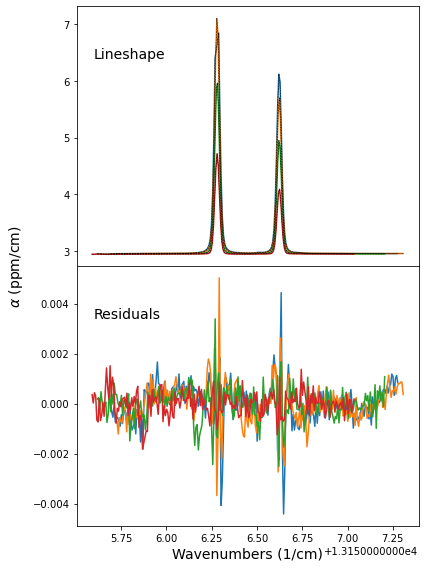

In [22]:
#%matplotlib notebook

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(2, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    line = noise_scale * mean_func(x[i]).numpy().flatten()
    ax[0].plot(x[i][:, 0], line, color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line - y[i], color=colors[i])

ax[0].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[0].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

## Adding Gaussian Processes

In [23]:
#Create gpflow model
gpflow.config.set_default_jitter(1e-06)

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Noise variance is around 1e-6 or 1e-07, which is an issue for GPflow
#To avoid numerical problems, scale output by noise standard deviation so noise variance will be order 1
test_y[:, 0] /= noise_scale

#Specify kernel that ignores the dimension specifying just the dataset index
kern = gpflow.kernels.SquaredExponential(lengthscales=1.0*(np.amax(test_x[:, :-1], axis=0)
                                                           - np.amin(test_x[:, :-1], axis=0)),
                                         active_dims=[0, 1, 2])

#Define our Gaussian process regression model
# gpr = SwitchedGPR(data=(test_x, test_y),
#                   kernel=kern,
#                   mean_function=mean_func,
#                   noise_variance=[1.0]*len(y))

#To save computation time, can also try with sparse GP model using inducing points
induce_pts = gpflow.inducing_variables.InducingPoints(np.vstack([xdat[np.random.choice(xdat.shape[0], size=10, replace=False)]
                                                                 for xdat in x]))
gpr = gpflow.models.SGPR(data=(test_x, test_y[:, :1]), #Have not implemented switched likelihood with sparse GPR yet
                         kernel=kern,
                         inducing_variable=induce_pts,
                         mean_function=mean_func,
                         noise_variance=1.0,
                         num_latent_gps=1)

#Can even go to sparse variational GP to get access to likelihood
#But maybe don't... becomes very slow to train and if have lots of datasets, likely to get awkward
#In a sense, a single noise variance still captures idea that some datasets may be less reliable...
#If only because will predict higher uncertainty at conditions (T and P) of that dataset
# gpr = gpflow.models.SVGP(kernel=kern,
#                          likelihood=gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0) for i in range(len(x))]),
#                          inducing_variable=induce_pts,
#                          mean_function=mean_func,
#                          num_latent_gps=1)

(928, 4)
(928, 2)


In [24]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SGPR.mean_function.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SGPR.mean_function.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
SGPR.mean_function.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
SGPR.mean_function.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
SGPR.mean_function.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


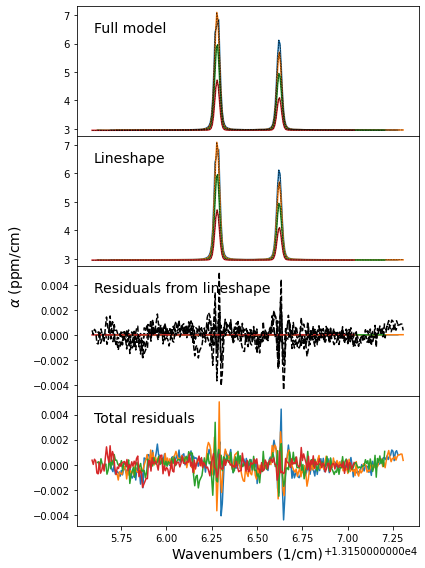

In [25]:
#%matplotlib notebook

#Predictions before training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], line - mean, color=colors[i])
    ax[2].plot(x[i][:, 0], line - y[i], 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Residuals from lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Total residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

In [26]:
%%time

#Note that optimizing with a Gaussian Process changes the objective function
#This means that the parameter values found with least-squares for the lineshape model may not be the same
#So we could freeze the lineshape model parameters and only optimize the GP model accounting for everything else...
#That would be fine for just estimating how the residuals and overall uncertainties vary with conditions
#But it's a little inconsistent with the overall model including the GP, so here we optimize everything

#You could also easily argue that optimizing both the model parameters and GP together is already inconsistent
#It is if you want reasonable priors; here, the priors on the lineshape parameters are delta functions
#That way, the likelihood has a closed-form solution (the GP parameter priors can be integrated out)
#Otherwise, you'd need MCMC to figure out the best parameters

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

CPU times: user 3min 46s, sys: 55.3 s, total: 4min 41s
Wall time: 2min 47s


In [27]:
opt_logs

      fun: 1156.0151107304523
 hess_inv: <217x217 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.76318480e-05,  1.08752284e-02,  8.17895188e-03,  0.00000000e+00,
       -4.54232643e-05,  2.19081322e-03,  4.33189410e-03,  0.00000000e+00,
        6.20783220e-05, -4.61224146e-03, -4.10815627e-03,  0.00000000e+00,
        5.13611110e-05, -4.59266979e-03, -2.68557269e-03,  0.00000000e+00,
        1.66289871e-05, -6.79338111e-03, -1.96859564e-03,  0.00000000e+00,
       -7.12026254e-04, -2.21760638e-03, -1.20640890e-03,  0.00000000e+00,
        1.96156127e-05, -6.07537936e-03, -1.64068364e-03,  0.00000000e+00,
       -1.45005680e-05, -4.33564398e-03, -4.43755996e-04,  0.00000000e+00,
        1.17799668e-03,  1.55693804e-03,  8.41713600e-04,  0.00000000e+00,
        6.03632717e-05,  6.69948897e-03,  6.27380234e-03,  0.00000000e+00,
       -2.57666628e-05, -1.28460384e-03,  1.73439036e-03,  0.00000000e+00,
        1.07190156e-04,  2.17692065e-03,  3.40206853e-03,  0.00000000e+00,

In [28]:
# tensor_data = tuple(map(tf.convert_to_tensor, (test_x, test_y)))

# svgp_loss =  gpr.training_loss_closure(tensor_data, compile=True)

# gpflow.set_trainable(gpr.q_mu, False)
# gpflow.set_trainable(gpr.q_sqrt, False)

In [29]:
# %%time

# natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=1.0)
# adam_opt = tf.optimizers.Adam(0.01)

# for _ in range(100):
#     #svgp_loss = gpr.training_loss_closure(next(data_minibatch_it))
#     natgrad_opt.minimize(svgp_loss, var_list=[(gpr.q_mu, gpr.q_sqrt)])
#     adam_opt.minimize(svgp_loss, var_list=gpr.trainable_variables)
# 
# #Takes about 12 minutes with SVGP

In [30]:
#Assuming lineshape model makes up most of loss, now freeze those parameters...
for param in gpr.mean_function.trainable_parameters:
    gpflow.set_trainable(param, False)

In [31]:
%%time

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

CPU times: user 1min 52s, sys: 10 s, total: 2min 2s
Wall time: 1min 44s


In [32]:
opt_logs

      fun: 1116.243047100789
 hess_inv: <165x165 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.33442730e-004, -1.13881973e-004, -1.31686182e-004,
        0.00000000e+000,  1.72714144e-207, -1.00254597e-201,
        3.59757727e-207,  0.00000000e+000,  2.79118971e-006,
        1.32840137e-003, -9.38700186e-006,  0.00000000e+000,
        1.58337631e-136, -1.53596625e-130, -1.60234946e-135,
        0.00000000e+000, -6.84579316e-026, -4.95361836e-023,
       -7.18963214e-025,  0.00000000e+000,  2.87075634e-005,
       -1.15735786e-003, -6.56439205e-005,  0.00000000e+000,
        1.62549997e-027, -1.38846438e-023,  2.03276143e-026,
        0.00000000e+000,  6.69915294e-007,  4.49032232e-004,
        5.96440624e-006,  0.00000000e+000, -1.79856361e-090,
       -1.10193964e-086, -1.69072827e-090,  0.00000000e+000,
       -3.14798056e-007,  5.71197850e-004, -2.23412578e-006,
        0.00000000e+000,  9.28916246e-168,  2.39124577e-163,
        1.72310389e-167,  0.00000000e+000, -3.

In [33]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SGPR.mean_function.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SGPR.mean_function.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
SGPR.mean_function.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
SGPR.mean_function.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
SGPR.mean_function.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


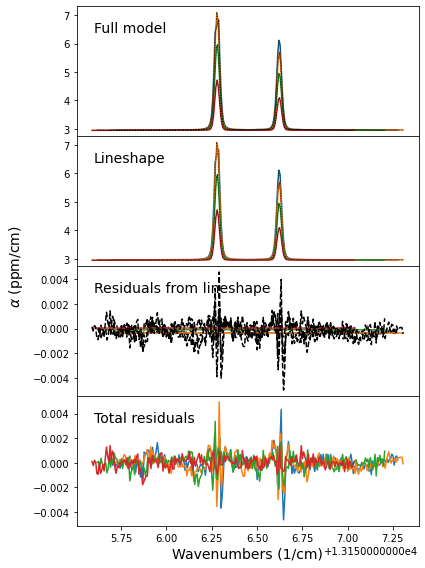

In [34]:
#Predictions after training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], line - mean, color=colors[i])
    ax[2].plot(x[i][:, 0], line - y[i], 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Residuals from lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Total residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

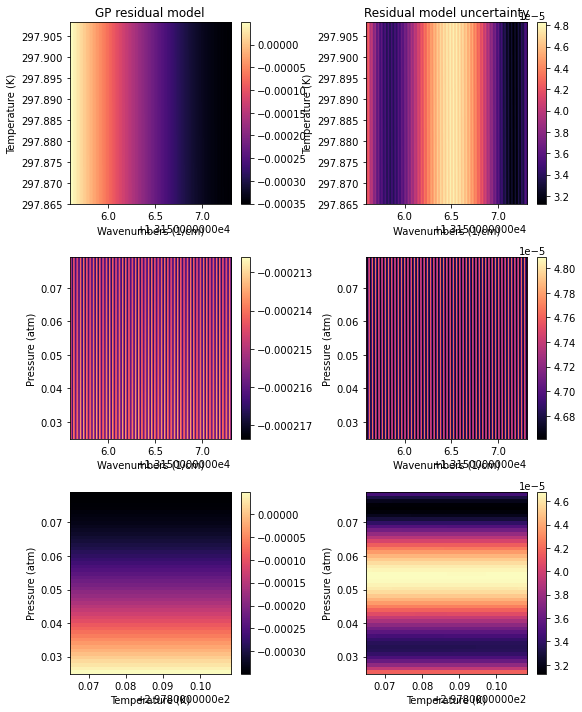

In [35]:
#Look at uncertainty as a function of wavenumber, temperature, pressure
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_vals = np.linspace(np.min(test_x[:, 1]), np.max(test_x[:, 1]), 50)
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 50)

xt_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, t_vals)]).T
xt_grid = np.hstack([xt_grid, np.average(p_vals)*np.ones((xt_grid.shape[0], 1))])
xp_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, p_vals)]).T
xp_grid = np.vstack([xp_grid[:, 0], np.average(t_vals)*np.ones(xp_grid.shape[0]), xp_grid[:, 1]]).T
tp_grid = np.vstack([a.flatten() for a in np.meshgrid(t_vals, p_vals)]).T
tp_grid = np.hstack([np.average(x_vals)*np.ones((tp_grid.shape[0], 1)), tp_grid])

#Use likelihood for first dataset
xt_grid = np.hstack([xt_grid, np.zeros((xt_grid.shape[0], 1))])
xp_grid = np.hstack([xp_grid, np.zeros((xp_grid.shape[0], 1))])
tp_grid = np.hstack([tp_grid, np.zeros((tp_grid.shape[0], 1))])

fig, ax = plt.subplots(3, 2, figsize=(8, 10))

ax_labels = [('Wavenumbers (1/cm)', 'Temperature (K)'),
             ('Wavenumbers (1/cm)', 'Pressure (atm)'),
             ('Temperature (K)', 'Pressure (atm)')]

shapes = [(500, 50), (500, 50), (50, 50)]

extents = [(xt_grid[0, 0], xt_grid[-1, 0], xt_grid[0, 1], xt_grid[-1, 1]),
           (xp_grid[0, 0], xp_grid[-1, 0], xp_grid[0, 2], xp_grid[-1, 2]),
           (tp_grid[0, 1], tp_grid[-1, 1], tp_grid[0, 2], tp_grid[-1, 2])]

for i, grid in enumerate([xt_grid, xp_grid, tp_grid]):
    mean, var = gpr.predict_f(grid)
    res = noise_scale * (gpr.mean_function(grid) - mean)
    res = np.reshape(res, shapes[i])
    std = noise_scale * np.sqrt(var[:, 0])
    std = np.reshape(std, shapes[i])
    im_res = ax[i, 0].imshow(res.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    im_std = ax[i, 1].imshow(std.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    plt.colorbar(im_res, ax=ax[i, 0])
    plt.colorbar(im_std, ax=ax[i, 1])
    for j in range(2):
        ax[i, j].set_xlabel(ax_labels[i][0])
        ax[i, j].set_ylabel(ax_labels[i][1])

ax[0, 0].set_title('GP residual model')
ax[0, 1].set_title('Residual model uncertainty')
fig.tight_layout()
plt.show()

In [36]:
#Now lets say we want to know how the sensitivity of the residual at a specific condition to our a parameter
#So using the GP residual model at that wavenumber, T, and P as the "objective" and get gradients...

gpflow.set_trainable(gpr.mean_function.mean_funcs[10].params['gamma0'], True) #Must be trainable!

test_point = np.array([np.average(test_x, axis=0)])
test_point[:, -1] = 0 #Have to set data set index... technically part of model input

with tf.GradientTape() as tape:
    mean, var = gpr.predict_f(test_point)
    res = noise_scale * (gpr.mean_function(test_point) - mean)

tape.gradient(res, [gpr.mean_function.variables[17]]) #17 is gamma0 for line 10... can work on better way to locate/index

[<tf.Tensor: shape=(), dtype=float64, numpy=0.05643452253413296>]

## MCMC with GPflow and tensorflow-probability